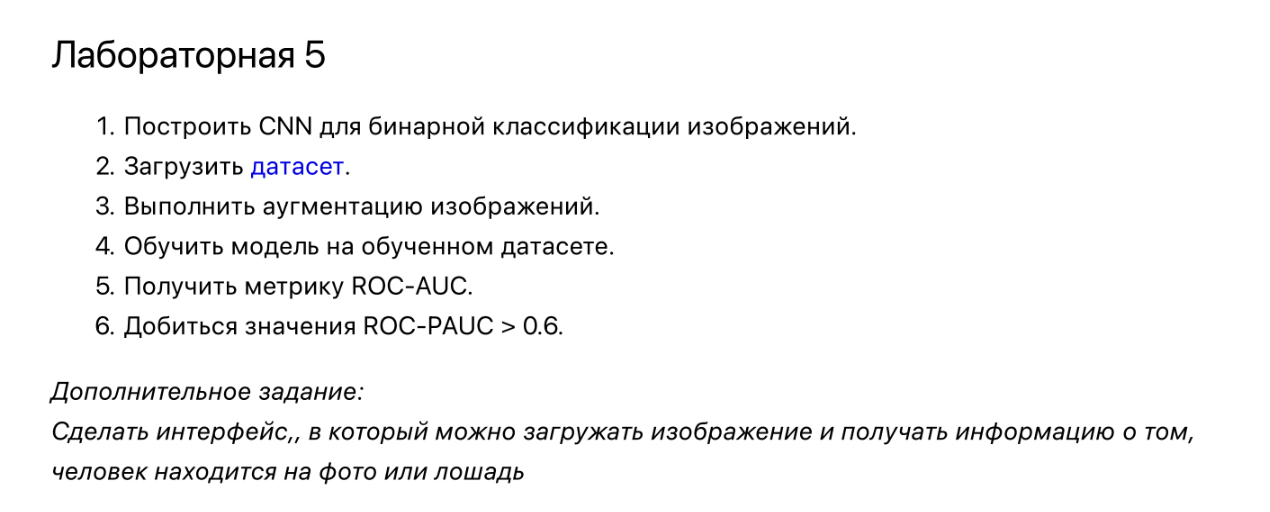

In [1]:
import os
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from torch.nn import (
    Module,
    Conv2d,
    MaxPool2d,
    Linear,
    CrossEntropyLoss,
    BatchNorm2d,
    Sequential,
    BatchNorm1d,
    AdaptiveAvgPool2d,
    Dropout,
    BCELoss,
)
from torch.nn.init import kaiming_normal_, zeros_
import torch.nn.functional as F
from torch.optim import Adam
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
IMG_FOLDERS = "../data/horse-or-human"
TENSOR_FOLDER = "/tensors/"

LABEL_CODE = {"horses": 0, "humans": 1}

BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 8
LR = 1e-3
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
os.listdir(path=IMG_FOLDERS)

['.DS_Store', 'humans', 'horses']

In [ ]:
def list_images(root_dir: str):
    exts = (".jpg", ".jpeg", ".png")
    items = []
    for cls, label in LABEL_CODE.items():
        folder = os.path.join(root_dir, cls)
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            print(fname)
            if fname.lower().endswith(exts):
                items.append((os.path.join(folder, fname), label))
    return items


class HorsesHumansDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = np.array(img)
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        y = torch.tensor(label, dtype=torch.float32)
        return img, y


# Albumentations transforms
train_tfms = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5
        ),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.3),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(),
    ]
)

valid_tfms = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(),
    ]
)

items = list_images(IMG_FOLDERS)
assert len(items) > 0, f"No images found in {IMG_FOLDERS}"
paths, labels = zip(*items)
idx = np.arange(len(items))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=SEED,
    stratify=labels,
)

train_items = [items[i] for i in train_idx]
val_items = [items[i] for i in val_idx]

train_ds = HorsesHumansDataset(train_items, transform=train_tfms)
val_ds = HorsesHumansDataset(val_items, transform=valid_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

len(train_ds), len(val_ds)

horse43-5.png
horse06-5.png
horse20-6.png
horse04-7.png
horse41-7.png
horse22-4.png
horse19-2.png
horse24-2.png
horse37-8.png
horse02-1.png
horse47-1.png
horse39-7.png
horse26-0.png
horse13-9.png
horse45-3.png
horse1-204.png
horse45-2.png
horse13-8.png
horse26-1.png
horse2-112.png
horse39-6.png
horse02-0.png
horse37-9.png
horse47-0.png
horse3-498.png
horse24-3.png
horse19-3.png
horse22-5.png
horse04-6.png
horse41-6.png
horse5-032.png
horse20-7.png
horse43-4.png
horse06-4.png
horse20-5.png
horse06-6.png
horse5-018.png
horse43-6.png
horse08-9.png
horse22-7.png
horse41-4.png
horse04-4.png
horse1-170.png
horse19-1.png
horse47-2.png
horse02-2.png
horse11-8.png
horse24-1.png
horse39-4.png
horse35-9.png
horse45-0.png
horse26-3.png
horse5-192.png
horse26-2.png
horse35-8.png
horse45-1.png
horse39-5.png
horse24-0.png
horse11-9.png
horse47-3.png
horse02-3.png
horse19-0.png
horse41-5.png
horse04-5.png
horse22-6.png
horse08-8.png
horse06-7.png
horse43-7.png
horse20-4.png
horse1-411.png
horse4-232.p

/Users/poslam/Downloads/projects/fefu/7/ds/.venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


(1026, 257)

In [5]:
# Define a simple CNN for binary classification
class SimpleCNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = BatchNorm2d(32)
        self.pool1 = MaxPool2d(2)

        self.conv2 = Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(64)
        self.pool2 = MaxPool2d(2)

        self.conv3 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = BatchNorm2d(128)
        self.pool3 = MaxPool2d(2)

        self.gap = AdaptiveAvgPool2d((1, 1))
        self.dropout = Dropout(p=0.3)
        self.fc = Linear(128, 1)  # logits

        # Kaiming init
        for m in [self.conv1, self.conv2, self.conv3]:
            kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                zeros_(m.bias)
        zeros_(self.fc.bias)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x  # logits


model = SimpleCNN().to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for X, y in tqdm(
        loader, desc="train" if is_train else "valid", leave=False
    ):
        X = X.to(DEVICE)
        y = y.to(DEVICE).unsqueeze(1)  # (N,1)
        logits = model(X)
        loss = criterion(logits, y)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * X.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())

    total = len(loader.dataset)
    avg_loss = total_loss / total
    logits = torch.cat(all_logits).squeeze(1).numpy()
    targets = torch.cat(all_targets).squeeze(1).numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid

    try:
        auc = roc_auc_score(targets, probs)
    except ValueError:
        auc = float("nan")
    return avg_loss, auc


best_auc = -1
history = []
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_auc = run_epoch(train_loader, model, optimizer)
    val_loss, val_auc = run_epoch(val_loader, model)
    scheduler.step(val_auc if not np.isnan(val_auc) else 0.0)
    history.append(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_auc": train_auc,
            "val_loss": val_loss,
            "val_auc": val_auc,
        }
    )
    print(
        f"Epoch {epoch:02d}/{EPOCHS}  |  train loss {train_loss:.4f} auc {train_auc:.3f}  |  val loss {val_loss:.4f} auc {val_auc:.3f}  |  {time.time()-t0:.1f}s"
    )
    if not np.isnan(val_auc) and val_auc > best_auc:
        best_auc = val_auc
        best_state = {
            k: v.cpu().clone() for k, v in model.state_dict().items()
        }

if best_auc >= 0 and "best_state" in locals():
    model.load_state_dict(best_state)

best_auc

train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 01/8  |  train loss 0.6381 auc 0.691  |  val loss 0.6852 auc 0.705  |  32.3s


Epoch 02/8  |  train loss 0.5703 auc 0.782  |  val loss 0.6258 auc 0.764  |  31.1s


Epoch 03/8  |  train loss 0.5497 auc 0.801  |  val loss 0.5194 auc 0.836  |  30.6s


Epoch 04/8  |  train loss 0.5374 auc 0.816  |  val loss 0.4753 auc 0.870  |  27.6s


Epoch 05/8  |  train loss 0.5079 auc 0.846  |  val loss 0.4813 auc 0.894  |  29.9s


Epoch 06/8  |  train loss 0.5242 auc 0.821  |  val loss 0.4339 auc 0.915  |  30.8s


Epoch 07/8  |  train loss 0.4642 auc 0.883  |  val loss 0.4049 auc 0.934  |  35.8s


Epoch 08/8  |  train loss 0.4881 auc 0.858  |  val loss 0.4383 auc 0.933  |  43.7s


0.9335393190355021

In [ ]:
model.eval()
all_probs, all_targets = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(DEVICE)
        logits = model(X)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(y.numpy())

all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)
val_auc = roc_auc_score(all_targets, all_probs)
print(f"Validation ROC-AUC: {val_auc:.3f}")

preds = (all_probs >= 0.5).astype(int)
acc = (preds == all_targets.astype(int)).mean()
print(f"Validation accuracy (0.5 threshold): {acc:.3f}")

Validation ROC-AUC: 0.934
Validation accuracy (0.5 threshold): 0.883
